In [111]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
from scipy.signal import correlate, find_peaks
import sounddevice as sd
import wave
# matplotlib qt

# Microphone Parameters
1. Mic Gain: 80
2. Recording Mode: Ambisonics FuMa
3. Recording Format (Sampling Rate): 48kHz
4. Recording Format (Bit depth): 24-bit

In [112]:
# Step 1: Define the parameters

# Reference: Patricio et. al in [14] E. Patricio, A. Ruminski, A. Kuklasinski, 
# L. Januszkiewicz, and T. Zernicki, "Toward Six Degrees of Freedom Audio 
# Recording and Playback Using Multiple Ambisonics Sound Fields," Paper 10141, 
# (2019 March.)

# Number of microphones
M = 3

# Order of Ambisonics
# We are using first order ambisonics in FuMa Format
# Note: WAV Format: W,X,Y,Z
P = 4

# Placing the ambisonic microphones in a triangle, this is the length of the 
# triangle (in centimeters)
triangle_side = 128

# Constants for the attenuation function
volume_threshold = 0.9
volume_range = 0.9
hoa_threshold = 0.9
hoa_range = 1.3

# Defining the indices of the channel
w_channel = 0
x_channel = 1
y_channel = 2
z_channel = 3

# Defining the microphone positions as a global parameter
mic_positions = np.zeros((3, 2))

mic_positions[0, :] = [0, 0]
mic_positions[1, :] = [triangle_side, 0]
mic_positions[2, :] = [triangle_side / 2, (triangle_side * np.sqrt(3)) / 2]

# Functions to calculate the attenuation of different microphones

In [113]:

def attenuation_and_rebalancing(d_m, t_l=volume_threshold, t_k=hoa_range, s_k_0=1.0, s_k_p_neg=-1.0, s_l_neg=-1.0):
    """
    Distance-dependent attenuation and component re-balancing function.

    Parameters:
    - d_m: distance to the m-th microphone
    - t_l: attenuation threshold
    - t_k: re-balancing threshold
    - s_k_0: slope for the 0th order component
    - s_k_p_neg: slope for higher-order components (p>0)
    - s_l_neg: slope for overall gain

    Returns:
    - Attenuation coefficient for the given distance
    """
    # Equation (3)
    def l(d_m):
        # Piecewise function where: 
        # l(d_m) = 0 if d_m <= t_l
        # l(d_m) = s_l(d_m - t_l) otherwise
        return np.where(d_m <= t_l, 0, s_l(d_m - t_l))

    # Equation (4)
    def k_p(d_m):
        # Piecewise function where: 
        # k_p(d_m) = 0 if d_m <= t_k
        # k_p(d_m) = s_k_p(d_m - t_k) otherwise
        return np.where(d_m <= t_k, 0, s_k_p(d_m - t_k))

    # Component in equation (3)
    def s_l(delta_d):
        # Adjust this function based on the specific behavior of s_l
        # For example, you can use a linear function: return s_l_neg * delta_d
        return s_l_neg * delta_d

    # Component in equation (4)
    def s_k_p(delta_d):
        # Adjust this function based on the specific behavior of s_k_p
        # For p=0, the slope is positive; for p>0, the slope is negative
        return np.where(delta_d <= 0, s_k_0, s_k_p_neg * delta_d)

    # Equation (2)
    return 10 ** ((l(d_m) + k_p(d_m)) / 20.0)

# Function to compute the distance between the interpolation points and the microphone
def compute_distance(interp_point, mic_number, triangle_side):
    
    # Euclidean distance between the interpolation point and the microphone

    distance = np.linalg.norm(interp_point - mic_positions[mic_number, :])
    return distance

# Function to extract the w, x, y, z channel signals
def extract_channels(mic_signal):
    # W Channel (Omni directional)
    w_signal = mic_signal[:, w_channel].astype(float)
    # X Channel
    x_signal = mic_signal[:, x_channel].astype(float)
    # Y Channel
    y_signal = mic_signal[:, w_channel].astype(float)
    # Z Channel
    z_signal = mic_signal[:, w_channel].astype(float)

    return w_signal, x_signal, y_signal, z_signal

# Getting the minimum length of the signals
def get_min_length(mic1_signal, mic2_signal, mic3_signal):
    return min(len(mic1_signal), len(mic2_signal), len(mic3_signal))


In [114]:
from pydub import AudioSegment

def get_num_channels(wav_file_path):
    audio = AudioSegment.from_file(file=wav_file_path, format="wav")  
    num_channels = audio.channels
    return num_channels

# Function to plot four different waves
def plot_waves(time_axis, signal, title, xlabel='Time', ylabel='Amplitude'):
    # Extracting the channels
    w, x, y, z = extract_channels(signal)

    # Plotting the W componment
    plt.subplot(2, 2, 1)
    plt.plot(time_axis, w, color='blue')
    plt.title(f'{title} W component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the X component
    plt.subplot(2, 2, 2)
    plt.plot(time_axis, x, color='green')
    plt.title(f'{title} X component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the Y component
    plt.subplot(2, 2, 3)
    plt.plot(time_axis, y, color='red')
    plt.title(f'{title} Y component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the Z component
    plt.subplot(2, 2, 4)
    plt.plot(time_axis, z, color='orange')
    plt.title(f'{title} Z component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.show()

# Function to plot a particular signal
def plot_signal(time, signal, title, color='blue'):
    plt.plot(time, signal, color)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()


# Loading the audio
We will plot the signals in its four channels (w, x, y, z) to analyze the data.

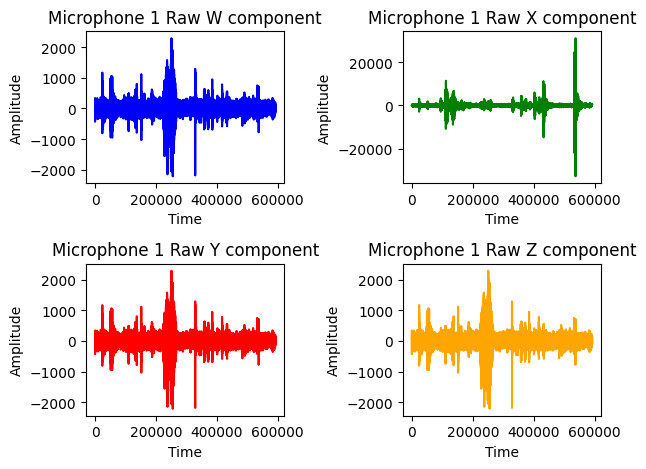

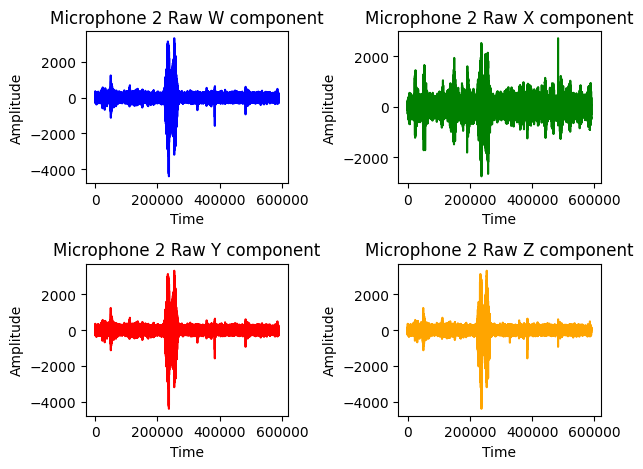

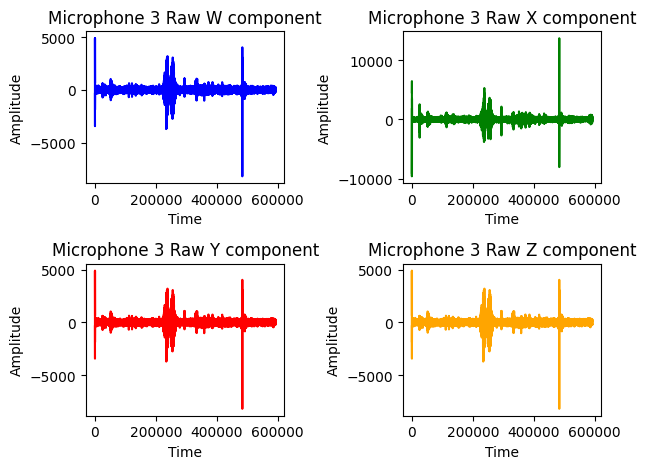

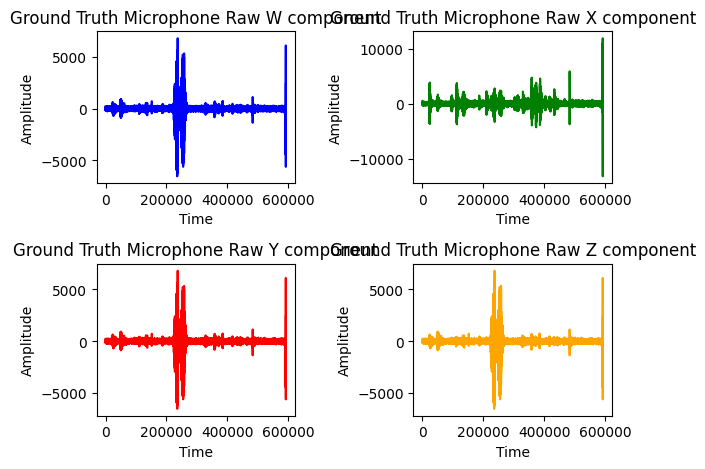

In [115]:
# Reading from the files
fs, mic1_signal = wavfile.read('../data/04_03/mic1_trimmed.WAV')
_, mic2_signal = wavfile.read('../data/04_03/mic2_trimmed.WAV')
_, mic3_signal = wavfile.read('../data/04_03/mic3_trimmed.WAV')
_, gt_signal = wavfile.read('../data/04_03/gt_trimmed.WAV')

# Original time_axes
time_1 = np.arange(1, mic1_signal.shape[0] + 1)
time_2 = np.arange(1, mic2_signal.shape[0] + 1)
time_3 = np.arange(1, mic3_signal.shape[0] + 1)
time_gt = np.arange(1, gt_signal.shape[0] + 1)

# Plotting the signals to check it out
plot_waves(time_1, mic1_signal, "Microphone 1 Raw")
plot_waves(time_2, mic2_signal, "Microphone 2 Raw")
plot_waves(time_3, mic3_signal, "Microphone 3 Raw")
plot_waves(time_gt, gt_signal, "Ground Truth Microphone Raw")


# Ensuring the data has the same number of channels
After we've used Audacity to crop the signals, we need to make sure the data has the same number of channels

In [116]:
# Getting the number of samples
mic1_samples = mic1_signal.shape[0]
mic2_samples = mic2_signal.shape[0]
mic3_samples = mic3_signal.shape[0]
gt_samples = gt_signal.shape[0]

min_length = min([mic1_samples, mic2_samples, mic3_samples, gt_samples])

# Cropping all of them to min_length
mic1_signal = mic1_signal[:min_length]
mic2_signal = mic2_signal[:min_length]
mic3_signal = mic3_signal[:min_length]
gt_signal = gt_signal[:min_length]

# Verifying that they are all min_length
assert(mic1_signal.shape[0] == mic2_signal.shape[0] == mic3_signal.shape[0] == gt_signal.shape[0])


# Extracting the channels of the ambisonic microphone signals


In [117]:
# Extracting the data from each channel
mic1_w_signal, mic1_x_signal, mic1_y_signal, mic1_z_signal = extract_channels(mic1_signal)
mic2_w_signal, mic2_x_signal, mic2_y_signal, mic2_z_signal = extract_channels(mic2_signal)
mic3_w_signal, mic3_x_signal, mic3_y_signal, mic3_z_signal = extract_channels(mic3_signal)
gt_w_signal, gt_x_signal, gt_y_signal, gt_z_signal = extract_channels(gt_signal)

# Synchonizing the data

We will use the following procedure to synchronize the recordings on the three microphones

1. Apply a Fourier Transform on the omni-directional signals of the data
2. Find the time at which the start and end A notes of the fourier transform are
3. Do a sanity check to make sure the length of time for all four of them are the same or around the same
4. If it's the same, make sure they're the same data. (Do some sort of correlation maybe? )

In [118]:
# Do the time lag thing that we initially did if there is no time


# Interpolation
Here, we will start interpolating the microphone signals that we have

In [122]:
# Forming the y_m_p array according to the paper
y_m_p = np.array([
    [mic1_w_signal, mic2_w_signal, mic3_w_signal],
    [mic1_x_signal, mic2_x_signal, mic3_x_signal],
    [mic1_y_signal, mic2_y_signal, mic3_y_signal],
    [mic1_z_signal, mic2_z_signal, mic3_z_signal]
])

# Interpolation point coordinates
interp_point = np.array([triangle_side / 2, (triangle_side * np.sqrt(3)) / 4])  # Ground truth point
print(f"Interpolated Point: {interp_point}")

# Compute the distance for all samples at once (This is the d_m function)
distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])

# Compute the attenuation coefficients for each microphone using broadcasting (This calculates the a_p(d_m))
a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])
a_p_values_reshaped = a_p_values.T[:, :, np.newaxis]

# Getting x_p 
x_p = np.sum(a_p_values_reshaped * y_m_p, axis=1)
x_p = x_p.T
print(x_p)

Interpolated Point: [64.         55.42562584]
[[-0.00142961  0.01696746 -0.00142961 -0.00142961]
 [-0.00186168  0.01753281 -0.00186168 -0.00186168]
 [-0.00206492  0.01798337 -0.00206492 -0.00206492]
 ...
 [-0.00038463  0.00156093 -0.00038463 -0.00038463]
 [-0.00038838  0.00148712 -0.00038838 -0.00038838]
 [-0.00038839  0.00146853 -0.00038839 -0.00038839]]


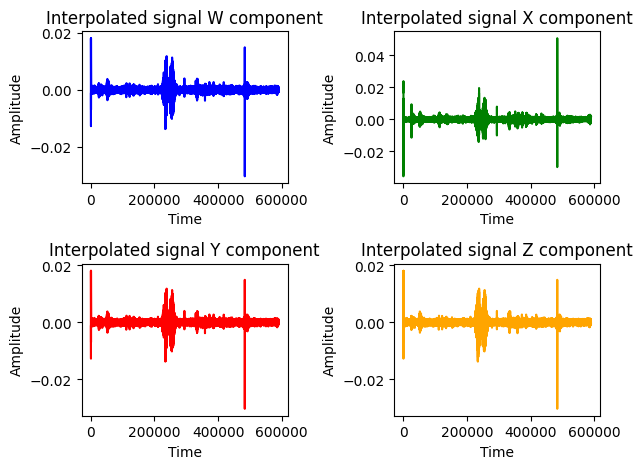

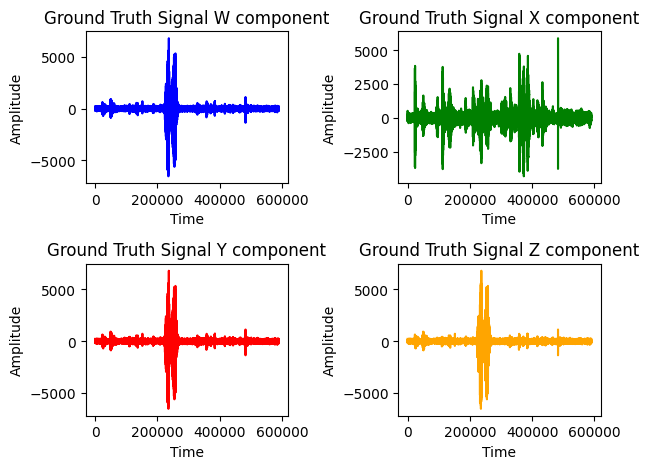

In [125]:
# Plotting the interpolated signal
time_axis = np.arange(1, x_p.shape[0] + 1)
assert(len(time_axis) == gt_signal.shape[0])
plot_waves(time_axis, x_p, 'Interpolated signal')

# Getting the ground truth signal
plot_waves(time_axis, gt_signal, 'Ground Truth Signal')

In [126]:
# Saving the interpolated point as a wave file
wavfile.write('output_centroid.wav', fs, x_p)

# Cross correlation
In this section, we will generate a bunch of points along the convex hull and perform interpolation on all those points. We will expect to see the best interpolation happening at the centroid

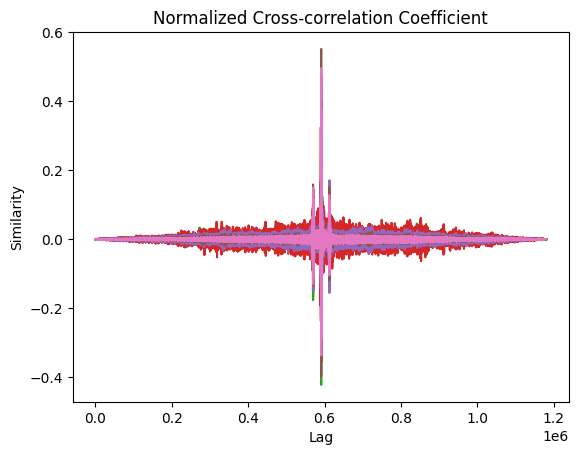

In [127]:
# Performing cross correlation
from scipy.signal import correlate

correlation_result = correlate(x_p, gt_signal, mode='full')

# Calculate normalized cross-correlation coefficient
norm_cross_corr_coeff = correlation_result / (len(x_p) * np.std(x_p) * np.std(gt_signal))

# Plot the similarity graph
plt.plot(norm_cross_corr_coeff)
plt.title('Normalized Cross-correlation Coefficient')
plt.xlabel('Lag')
plt.ylabel('Similarity')
plt.show()

# Verification of maximum correlation

In [128]:
# 1. Array of points of y-values
points = [35, 40, 45, 50, 55, 60, 65, 70, 75]
num_points = len(points)
signals = []

# Array of cross correlation values
cross_corr_values = []

# Getting the values of cross_correlations
for i in range(num_points):
    y_point = points[i]
    interp_point = np.array([triangle_side / 2, y_point])
    distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])
    a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])
    a_p_values_reshaped = a_p_values.T[:, :, np.newaxis]
    x_p = np.sum(a_p_values_reshaped * y_m_p, axis=1)
    x_p = x_p.T
    signals.append(x_p)

print(signals)

[array([[-1.30580295e-04,  1.53641573e-03, -1.30580295e-04,
        -1.30580295e-04],
       [-1.69489284e-04,  1.58869470e-03, -1.69489284e-04,
        -1.69489284e-04],
       [-1.88313084e-04,  1.62937471e-03, -1.88313084e-04,
        -1.88313084e-04],
       ...,
       [-3.70497579e-05,  1.35404721e-04, -3.70497579e-05,
        -3.70497579e-05],
       [-3.76166328e-05,  1.28978017e-04, -3.76166328e-05,
        -3.76166328e-05],
       [-3.76939681e-05,  1.26781659e-04, -3.76939681e-05,
        -3.76939681e-05]]), array([[-0.00041031,  0.00486382, -0.00041031, -0.00041031],
       [-0.00053407,  0.00502636, -0.00053407, -0.00053407],
       [-0.00059252,  0.00515547, -0.00059252, -0.00059252],
       ...,
       [-0.00011125,  0.00044479, -0.00011125, -0.00011125],
       [-0.00011243,  0.00042375, -0.00011243, -0.00011243],
       [-0.00011247,  0.00041819, -0.00011247, -0.00011247]]), array([[-0.00129618,  0.0153834 , -0.00129618, -0.00129618],
       [-0.00168791,  0.015896  , 

In [129]:
# Cross correlating the signals
i = 0
for signal in signals:
    print(f"Correlating: {i}")
    print(f"Correlating current y-point: {points[i]}")
    cross_corr = correlate(gt_signal, signal, mode='same')
    print(f"Successfully correlated: {i}")
    cross_corr_values.append(cross_corr)
    i += 1
    

# Identifying time shifts
time_shifts = [np.argmax(cross_corr) - (len(gt_signal) - 1) for cross_corr in cross_corr_values]

# Quantifying similarities
max_corr_values = [np.max(cross_corr) for cross_corr in cross_corr_values]
print(f"Max correlation values: {max_corr_values}")

most_similar_index = np.argmax(max_corr_values)
most_similar_signal = signals[most_similar_index]

# We expect it to say 55
print(f"The most signal is the one with y value: {points[most_similar_index]}")

Correlating: 0
Correlating current y-point: 45
Successfully correlated: 0
Correlating: 1
Correlating current y-point: 50
Successfully correlated: 1
Correlating: 2
Correlating current y-point: 55
Successfully correlated: 2
Correlating: 3
Correlating current y-point: 60
Successfully correlated: 3
Correlating: 4
Correlating current y-point: 65
Successfully correlated: 4
Max correlation values: [13154.397085944063, 41512.1517170575, 131229.4349516881, 414962.79453755845, 1312217.7329966547]
The most signal is the one with y value: 65


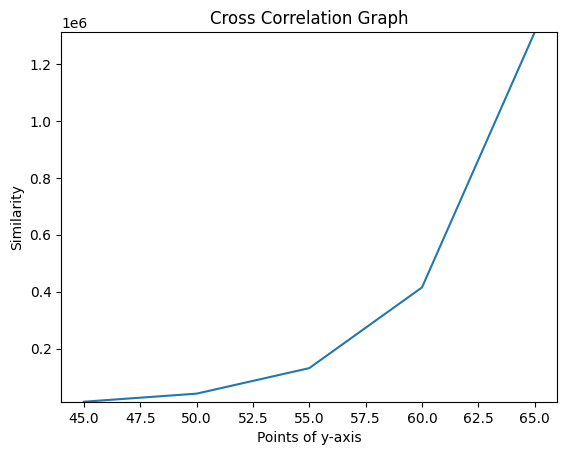

In [130]:
# Normalize the max_corr_values:

# Plotting the graph
plt.plot(points, max_corr_values)
lower_bound = np.min(max_corr_values) - 0.0000000001
upper_bound = np.max(max_corr_values) + 0.0000000001
plt.ylim(lower_bound, upper_bound)
plt.title("Cross Correlation Graph")
plt.xlabel("Points of y-axis")
plt.ylabel("Similarity")
plt.show()
